# Overview
This notebook provides instructions on how to use CEFCON for the following tasks: 
- constructing cell-lineage-specific GRNs,
- identifying driver regulators,
- finding regulon-like gene modules,
- visualizing and analyzing the results.

We use the scRNA-seq data from Nestorowa et al. (2016, Blood), which is about mouse hematopoietic stem and progenitor cell differentiation.

### Contents
- [1. Load the preprocessed data](#section1)
- [2. Construct cell-lineage-specific GRNs](#section2)
- [3. Identify driver regulators for each developmental lineage](#section3)
- [4. Find regulon-like gene modules (RGMS)](#section4)
- [5. Visualization and analyses of results](#section5)

In [2]:
import cefcon as cf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = [6, 4.5]

<a id = "section1"> </a>
## 1. Load the preprocessed data

Here, we use the mouse hematopoiesis data provided by [Nestorowa et al. (2016, Blood)](https://doi.org/10.1182/blood-2016-05-716480). Please check this [notebook]() to learn about scRNA-seq data preprocessing.

In [4]:
# Load the preprocessed data
adata = cf.datasets.mouse_hsc_nestorowa16()
adata

Load mouse_hsc_nestorowa16_v0.h5ad


AnnData object with n_obs × n_vars = 1645 × 3000
    obs: 'E_pseudotime', 'GM_pseudotime', 'L_pseudotime', 'label_info', 'n_genes', 'leiden', 'cell_type_roughly', 'cell_type_finely'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'E_pseudotime_logFC', 'GM_pseudotime_logFC', 'L_pseudotime_logFC'
    uns: 'cell_type_finely_colors', 'cell_type_roughly_colors', 'draw_graph', 'hvg', 'leiden', 'leiden_colors', 'lineages', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

Load the prior gene interaction network

In [ ]:
prior_network = cf.datasets.load_human_prior_interaction_network(dataset='nichenet')
# Convert the gene symbols of the prior gene interaction network to the mouse gene symbols
prior_network = cf.datasets.convert_human_to_mouse_network(prior_network)

Alternatively, you can directly specify the file path of the input prior interaction network and import the specified file using the `cf.data_preparation` function.

In [5]:
prior_network = './Reference_Networks/combined_network_Mouse.txt'

<a id = "section2"> </a>
## 2. Construct cell-lineage-specific GRNs


In [6]:
data = cf.data_preparation(adata, prior_network)

[0] - Data loading and preprocessing...
Consider the input data with 3 lineages:
  Lineage - E_pseudotime:
    2971 extra edges (Spearman correlation > 0.6) are added into the prior gene interaction network.
    Total number of edges: 93601.
    n_genes × n_cells = 2979 × 1065
  Lineage - GM_pseudotime:
    100 extra edges (Spearman correlation > 0.6) are added into the prior gene interaction network.
    Total number of edges: 93701.
    n_genes × n_cells = 2979 × 882
  Lineage - L_pseudotime:
    4 extra edges (Spearman correlation > 0.6) are added into the prior gene interaction network.
    Total number of edges: 93705.
    n_genes × n_cells = 2979 × 843


Assign a CUDA device:

In [7]:
CUDA = '0'

Lineage-by-lineage computation:

In [8]:
%%time
cefcon_results_dict = {}
for li, data_li in data.items():
    # We suggest setting up multiple repeats to minimize the randomness of the computation.
    cefcon_GRN_model = cf.NetModel(epochs=350, repeats=3, cuda=CUDA, seed=-1)
    cefcon_GRN_model.run(data_li)

    cefcon_results = cefcon_GRN_model.get_cefcon_results(edge_threshold_avgDegree=8)
    cefcon_results_dict[li] = cefcon_results

[1] - Constructing cell-lineage-specific GRN...
  Lineage - E_pseudotime: 


  Iter: 3/3: 100%|██████████████| 350/350 [00:24<00:00, 14.23it/s, loss=0.000959, min_loss=0.000167]


[1] - Constructing cell-lineage-specific GRN...
  Lineage - GM_pseudotime: 


  Iter: 3/3: 100%|███████████████| 350/350 [00:24<00:00, 14.08it/s, loss=0.000305, min_loss=9.45e-5]


[1] - Constructing cell-lineage-specific GRN...
  Lineage - L_pseudotime: 


  Iter: 3/3: 100%|██████████████| 350/350 [00:24<00:00, 14.05it/s, loss=0.000463, min_loss=0.000127]


CPU times: user 4min 57s, sys: 3.36 s, total: 5min 1s
Wall time: 3min 45s


<a id = "section4"> </a>
## 4. Idenytify driver regulators for each lineage


In [9]:
%%time
for li, result_li in cefcon_results_dict.items():
    print(f'Lineage - {li}:')
    result_li.gene_influence_score()
    result_li.driver_regulators()

Lineage - E_pseudotime:
[2] - Identifying driver regulators...
Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-29
  Solving MFVS problem...
    180 critical nodes are found.
    0 nodes left after graph reduction operation.
  180 MFVS driver genes are found.
  Solving MDS problem...
    14 critical nodes are found.
    1195 nodes left after graph reduction operation.
    Solving the Integer Linear Programming problem on the reduced graph...
      Solving by GUROBI...(optimal value with GUROBI:133.0,  status:optimal)
  147 MDS driver genes are found.
Lineage - GM_pseudotime:
[2] - Identifying driver regulators...
  Solving MFVS problem...
    218 critical nodes are found.
    0 nodes left after graph reduction operation.
  218 MFVS driver genes are found.
  Solving MDS problem...
    18 critical nodes are found.
    1773 nodes left after graph reduction operation.
    Solving the Integer Linear Programming problem on the reduced graph...
      Sol

<a id = "section5"> </a>
## 5. Identify regulon-like gene modules (RGMs)


In [10]:
%%time
for li, result_li in cefcon_results_dict.items():
    print(f'Lineage - {li}:')
    result_li.RGM_activity()

Lineage - E_pseudotime:
[3] - Identifying regulon-like gene modules...
Done!
Lineage - GM_pseudotime:
[3] - Identifying regulon-like gene modules...
Done!
Lineage - L_pseudotime:
[3] - Identifying regulon-like gene modules...
Done!
CPU times: user 872 ms, sys: 780 ms, total: 1.65 s
Wall time: 1min


<a id = "section6"> </a>
## 6. Visualization and analyses of results

In [11]:
# Check the names of lineages
print(list(data.keys()))

['E_pseudotime', 'GM_pseudotime', 'L_pseudotime']


Here, we choose one lineage for further analysis.

In [12]:
lineage = 'E_pseudotime'
result = cefcon_results_dict[lineage]

\> Plot degree distribution of the inferred lineage-specific GRN and show some key topological metrics

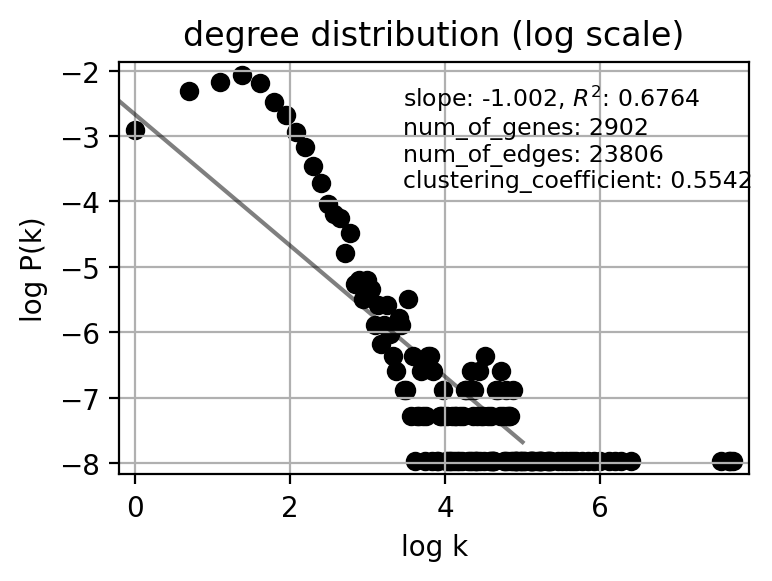

In [13]:
result.plot_network_degree_distribution()

\> Plot gene embedding clusters

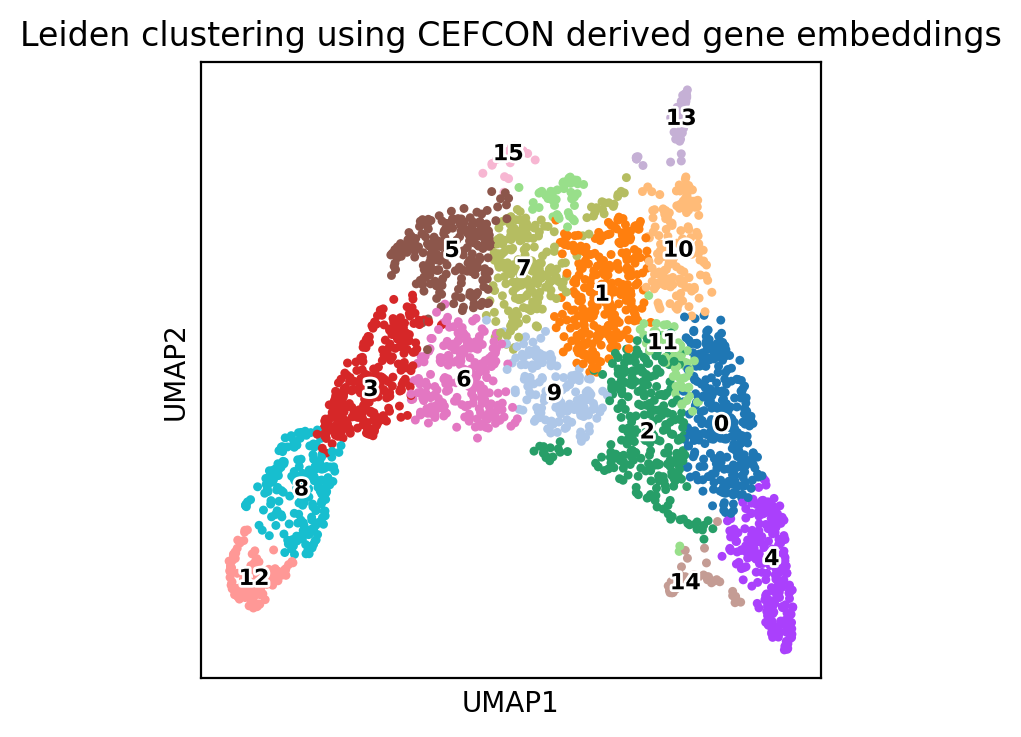

In [14]:
result.plot_gene_embedding_with_clustering(n_neighbors=30, resolution=1)

\> Plot influence scores of driver regulators

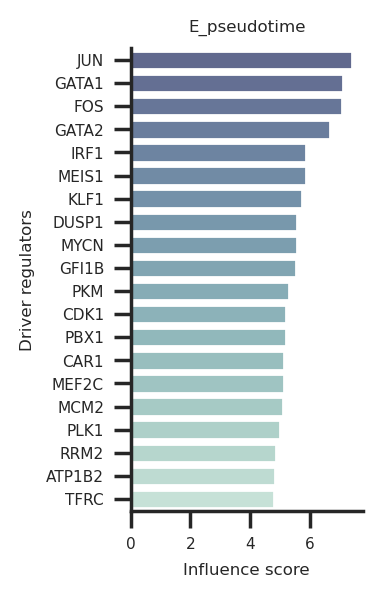

In [15]:
result.plot_influence_score()

\> Plot Venn diagram of MDS driver genes, MFVS driver genes and top-ranked genes

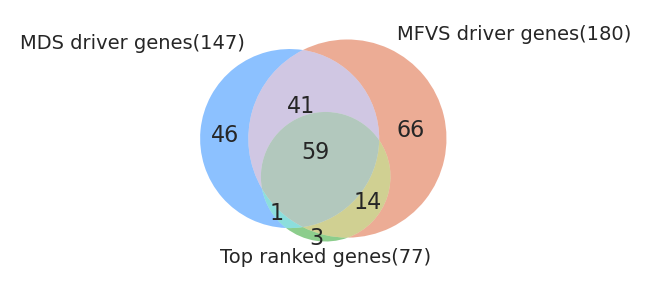

In [16]:
result.plot_driver_genes_Venn()

\> Plot heat map of the activity matrix of RGMs

<Figure size 600x450 with 0 Axes>

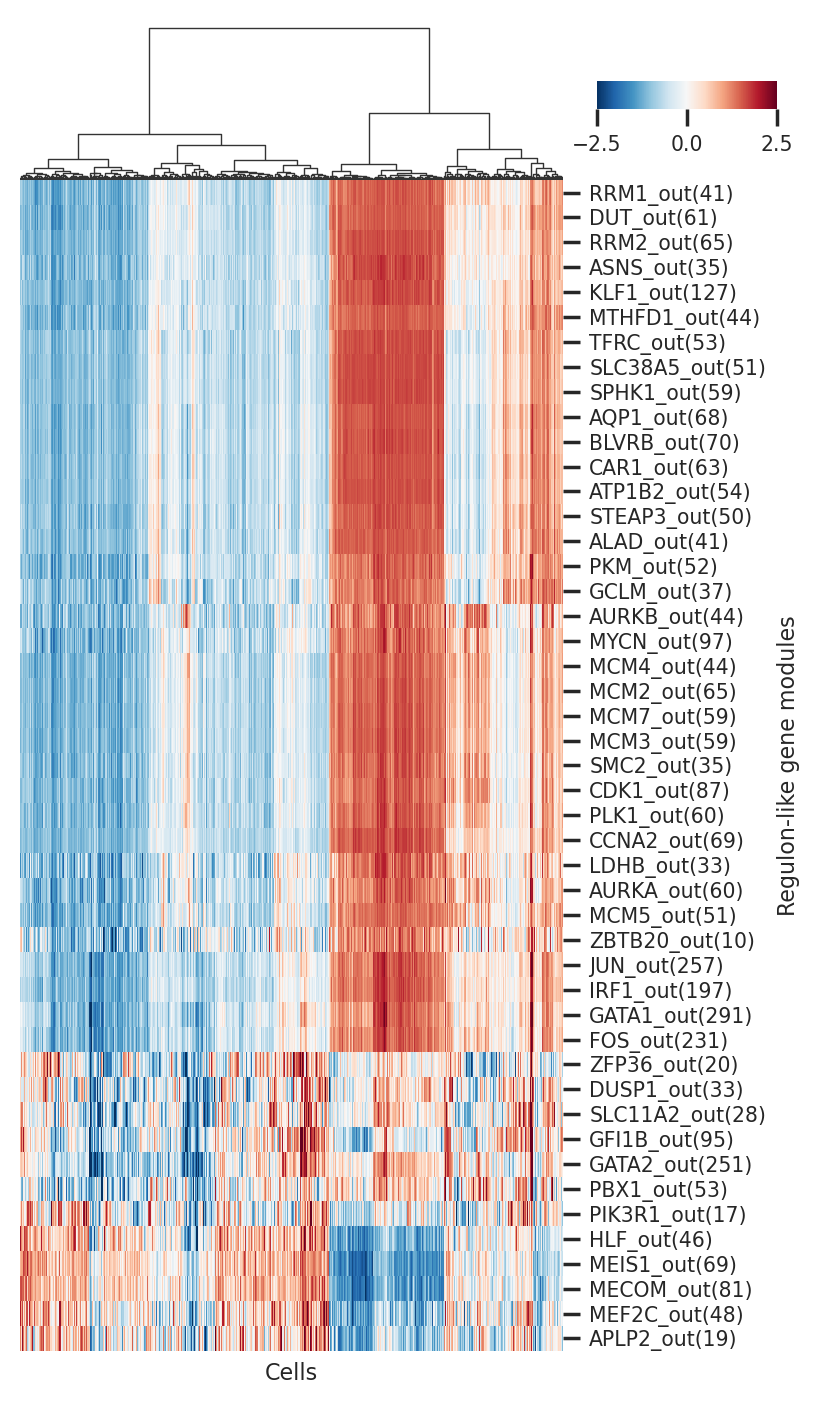

In [17]:
result.plot_RGM_activity_heatmap(cell_label=None, type='out')

\> Plot network with user specified genes

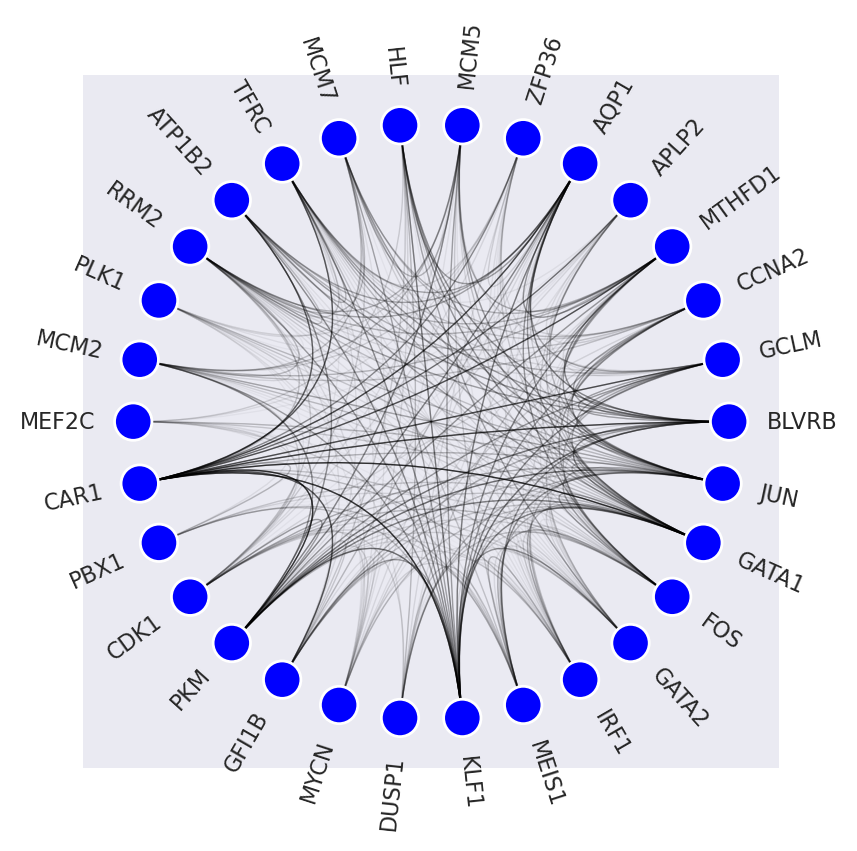

In [18]:
genes = result.driver_regulator.index[0:30]

network = result.plot_network(genes)

\> Plot controllability metrics of all the lineages

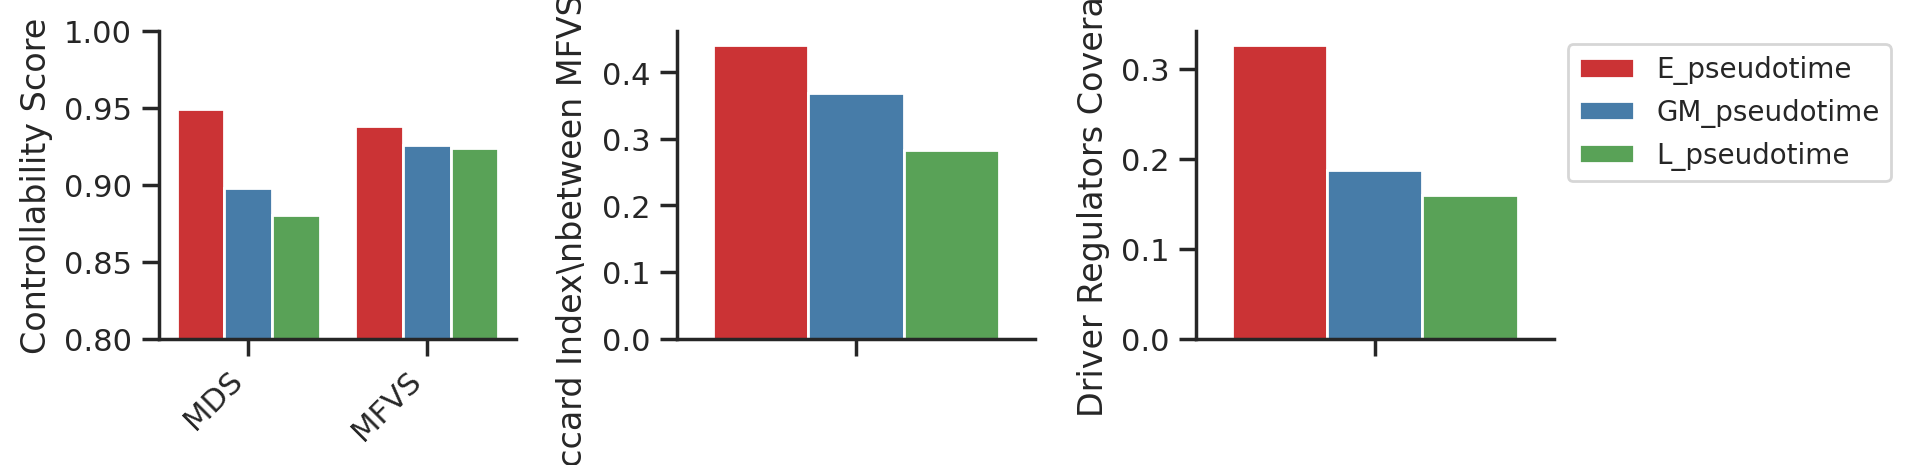

In [19]:
cf.utils.plot_controllability_metrics(cefcon_results_dict, return_value=False)
